In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import soundfile as sf

from configs.params_v1 import reorder_feats
from paths import DATA_DIR

import utils_ema.ema_dataset

from scipy.stats import pearsonr
from metrics import normalized_dtw_score
from utils import plot_art_14

from tqdm import tqdm

/home/anli/Desktop/art-tts/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Quantitative evaluation of the arttts generated samples from the SPARC-extracted EMA features with the best and worst PCC score (Careful, may be influenced by the quality ofthe linear transfo. The PCC scores are computed on linearly transformed features (from MNGU0 space to concerned speaker) while the reconstruction takes an MNGU0-space input)

We want to assess how powerful the HiFi GAN is and how much it relies on accurate EMA/articulatory predictions.

We also test the sensitivity to pitch and speaker embedding

# MSPKA_EMA_ita

In [3]:
from utils_dataset.mspka import get_MSPKA_ema

dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "olm", "lls"]
spkmetadata_filenames = ["mixed_speaker_metadata_100Hz.joblib", "nonmixed_speaker_metadata_100Hz.joblib", "speaker_metadata_100Hz.joblib"]
spkmetadata_filename = "mixed_speaker_metadata_100Hz.joblib"
processed_data_dir = DATA_DIR / dataset / "processed_data"
for speaker in speakers[:3]:
    print(f"Processing speaker: {speaker}")
    for spkmetadata_filename in spkmetadata_filenames[:1]:
        if not (processed_data_dir / speaker / spkmetadata_filename).exists():
            print(f"File {spkmetadata_filename} does not exist for speaker {speaker}.")
            continue
        spkmeta = joblib.load(processed_data_dir / f"{speaker}/{spkmetadata_filename}")
        ids = spkmeta.list_valid_ids()
        # get the PCC scores and other metadata for each sentence
        pcc_scores = []
        filestems = []
        splits = []
        durations = []
        for id in ids:
            sentencemeta = spkmeta.sentence_info[id]
            filestems.append(sentencemeta.filestem)
            splits.append(sentencemeta.split)
            pcc_scores.append(sentencemeta.PCC_score)
            durations.append(sentencemeta.duration)

        summary_df = pd.DataFrame({
                                    "filestem": filestems,
                                    "split": splits,
                                    "pcc": pcc_scores,
                                    "duration": durations
                                })
        summary_df = summary_df.sort_values(by="pcc", ascending=False)

    # get their sparc reconstruction
    arttts_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "arttts_pred" / "v1" / "grad_4750_align"
    sparc_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "emasrc"
    gt_ema_dir = DATA_DIR / dataset / "src_data" / speaker
    linearmodel_dir = DATA_DIR / dataset / "processed_data" / speaker / "linear_models"
    linearmodel = joblib.load(linearmodel_dir / "mixed_model_full_100Hz.joblib")
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    analysis_dir.mkdir(parents=True, exist_ok=True)

    data = []
    for i, row in tqdm(summary_df.iterrows()):
        new_row = {
            "filestem": row["filestem"],
            "split": row["split"],
            "pcc": row["pcc"],
            "duration": row["duration"]
        }
        filestem = row["filestem"]
        arttts_ema = np.load(arttts_pred_dir / f"{filestem}.npy")
        enc_ema = arttts_ema[:12,:].T
        dec_ema = arttts_ema[14:26,:].T
        sparc_ema = np.load(sparc_pred_dir / f"{filestem}.npy")[:,:12]
        gt_ema = get_MSPKA_ema(gt_ema_dir / f"{filestem}.ema")[::8,:12]
        gt_ema = (gt_ema - np.mean(gt_ema, axis=0)) / np.std(gt_ema, axis=0)
        enc_ema = (enc_ema - np.mean(enc_ema, axis=0)) / np.std(enc_ema, axis=0)
        dec_ema = (dec_ema - np.mean(dec_ema, axis=0)) / np.std(dec_ema, axis=0)
        sparc_ema = (sparc_ema - np.mean(sparc_ema, axis=0)) / np.std(sparc_ema, axis=0)
        enc_ema = linearmodel.predict(enc_ema)
        dec_ema = linearmodel.predict(dec_ema)
        sparc_ema = linearmodel.predict(sparc_ema)
        #gt_ema = linearmodel.predict(gt_ema)
        dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(gt_ema, enc_ema)
        dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(gt_ema, dec_ema)
        dist_gt_sparc, y_gt_sparc_ada, y_sparc_14_ada = normalized_dtw_score(gt_ema, sparc_ema)
        pearson_enc, _ = pearsonr(y_gt_enc_ada, y_enc_14_ada)
        pearson_dec, _ = pearsonr(y_gt_dec_ada, y_dec_14_ada)
        pearson_sparc, _ = pearsonr(y_gt_sparc_ada, y_sparc_14_ada)
        new_row["dtw_gt_enc"] = dist_gt_enc
        new_row["dtw_gt_dec"] = dist_gt_dec
        new_row["dtw_gt_sparc"] = dist_gt_sparc
        new_row["pcc_gt_enc"] = np.mean(pearson_enc[:12])
        new_row["pcc_gt_dec"] = np.mean(pearson_dec[:12])
        new_row["pcc_gt_sparc"] = np.mean(pearson_sparc[:12])
        data.append(new_row)
    
    res_df = pd.DataFrame(data)
    res_df.to_csv(analysis_dir / "quanti_art_comp_align.csv", index=False)

Processing speaker: cnz


0it [00:00, ?it/s]

620it [00:14, 43.78it/s]


Processing speaker: olm


462it [00:13, 35.09it/s]


Processing speaker: lls


586it [00:12, 46.83it/s]


In [4]:
speaker = "cnz"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
cnz_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
cnz_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000,620.000000
mean,0.773684,5.587484,2.616910,2.486943,2.018662,0.643726,0.672329,0.805161
std,0.046497,1.871163,0.170109,0.162104,0.149628,0.052087,0.048311,0.034502
min,0.231894,1.920000,2.155120,2.021682,1.619147,0.462539,0.529346,0.627160
25%,0.753712,4.232500,2.504340,2.375222,1.919494,0.614654,0.642526,0.787620
50%,0.780234,5.370000,2.612598,2.477215,2.003510,0.646778,0.674352,0.810427
75%,0.800498,6.710000,2.717607,2.588053,2.098207,0.678385,0.707288,0.827039
max,0.854397,12.260000,3.151949,2.947578,2.723867,0.775130,0.794387,0.885387


In [5]:
speaker = "lls"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
lls_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
lls_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000,586.000000
mean,0.627293,5.551365,2.832790,2.693018,2.463146,0.523647,0.562604,0.672977
std,0.067808,1.840121,0.159721,0.158907,0.169688,0.065351,0.060872,0.060901
min,0.123739,2.110000,2.338517,2.226505,2.036138,0.232856,0.317397,0.372728
25%,0.591630,4.210000,2.727178,2.591055,2.355072,0.484696,0.528967,0.641849
50%,0.635380,5.300000,2.817967,2.692106,2.452128,0.530270,0.563073,0.680990
75%,0.673509,6.590000,2.935186,2.793241,2.550798,0.567925,0.604084,0.712680
max,0.762182,11.690000,3.413096,3.155421,3.103549,0.674990,0.704640,0.801137


In [6]:
speaker = "olm"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
olm_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
olm_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,0.751822,6.463420,2.642782,2.445957,2.119424,0.615877,0.665841,0.782090
std,0.047006,2.317318,0.175158,0.159852,0.163774,0.060806,0.051152,0.043406
min,0.491884,1.890000,2.138099,1.966543,1.710626,0.380715,0.439748,0.539484
25%,0.730930,4.800000,2.525390,2.335469,2.003495,0.577295,0.635739,0.761588
50%,0.759089,6.150000,2.624773,2.429422,2.094472,0.622515,0.670640,0.788047
75%,0.781873,7.870000,2.751600,2.547818,2.210880,0.658609,0.701942,0.812166
max,0.847333,14.570000,3.272140,3.117452,2.918181,0.765039,0.805339,0.868905


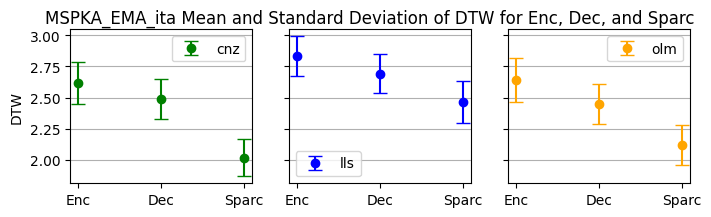

In [7]:
# Calculate mean and standard deviation for enc, dec, and sparc
means = [
    olm_df["dtw_gt_enc"].mean(),
    olm_df["dtw_gt_dec"].mean(),
    olm_df["dtw_gt_sparc"].mean()
]
stds = [
    olm_df["dtw_gt_enc"].std(),
    olm_df["dtw_gt_dec"].std(),
    olm_df["dtw_gt_sparc"].std()
]

# Labels for the bars
labels = ["Enc", "Dec", "Sparc"]

# Plot the bar chart
fig, ax = plt.subplots(1, 3, figsize=(8, 2), sharey=True, sharex=True)
#plot stds
ax[2].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='olm', color='orange')

means = [
    lls_df["dtw_gt_enc"].mean(),
    lls_df["dtw_gt_dec"].mean(),
    lls_df["dtw_gt_sparc"].mean()
]
stds = [
    lls_df["dtw_gt_enc"].std(),
    lls_df["dtw_gt_dec"].std(),
    lls_df["dtw_gt_sparc"].std()
]
ax[1].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='lls', color='blue')

means = [
    cnz_df["dtw_gt_enc"].mean(),
    cnz_df["dtw_gt_dec"].mean(),
    cnz_df["dtw_gt_sparc"].mean()
]
stds = [
    cnz_df["dtw_gt_enc"].std(),
    cnz_df["dtw_gt_dec"].std(), 
    cnz_df["dtw_gt_sparc"].std()
]
ax[0].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='cnz', color='green')

ax[0].set_ylabel("DTW")
plt.suptitle(f"{dataset} Mean and Standard Deviation of DTW for Enc, Dec, and Sparc")
ax[0].grid(axis='y')
ax[1].grid(axis='y')
ax[2].grid(axis='y')
ax[0].legend()
ax[1].legend()
ax[2].legend()
#plt.tight_layout()
plt.show()


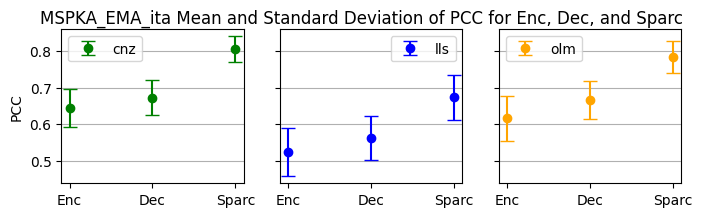

In [8]:
# Calculate mean and standard deviation for enc, dec, and sparc
means = [
    olm_df["pcc_gt_enc"].mean(),
    olm_df["pcc_gt_dec"].mean(),
    olm_df["pcc_gt_sparc"].mean()
]
stds = [
    olm_df["pcc_gt_enc"].std(),
    olm_df["pcc_gt_dec"].std(),
    olm_df["pcc_gt_sparc"].std()
]

# Labels for the bars
labels = ["Enc", "Dec", "Sparc"]

# Plot the bar chart
fig, ax = plt.subplots(1, 3, figsize=(8, 2), sharey=True, sharex=True)
#plot stds
ax[2].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='olm', color='orange')

means = [
    lls_df["pcc_gt_enc"].mean(),
    lls_df["pcc_gt_dec"].mean(),
    lls_df["pcc_gt_sparc"].mean()
]
stds = [
    lls_df["pcc_gt_enc"].std(),
    lls_df["pcc_gt_dec"].std(),
    lls_df["pcc_gt_sparc"].std()
]
ax[1].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='lls', color='blue')

means = [
    cnz_df["pcc_gt_enc"].mean(),
    cnz_df["pcc_gt_dec"].mean(),
    cnz_df["pcc_gt_sparc"].mean()
]
stds = [
    cnz_df["pcc_gt_enc"].std(),
    cnz_df["pcc_gt_dec"].std(), 
    cnz_df["pcc_gt_sparc"].std()
]
ax[0].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='cnz', color='green')

ax[0].set_ylabel("PCC")
plt.suptitle(f"{dataset} Mean and Standard Deviation of PCC for Enc, Dec, and Sparc")
ax[0].grid(axis='y')
ax[1].grid(axis='y')
ax[2].grid(axis='y')
ax[0].legend()
ax[1].legend()
ax[2].legend()
#plt.tight_layout()
plt.show()


# pb2007

In [9]:
from utils_dataset.pb2007 import get_pb2007_ema

dataset = "pb2007"
speakers = ["spk1"]
speaker = "spk1"
spkmetadata_filenames = ['1.0_speaker_metadata_100Hz.joblib',
                         '0.9_speaker_metadata_100Hz.joblib',
                        '0.8_speaker_metadata_100Hz.joblib',
                        '0.7_speaker_metadata_100Hz.joblib',
                        '0.6_speaker_metadata_100Hz.joblib',
                        '0.5_speaker_metadata_100Hz.joblib',
                        '0.4_speaker_metadata_100Hz.joblib',
                        '0.3_speaker_metadata_100Hz.joblib',
                        '0.2_speaker_metadata_100Hz.joblib',
                        '0.1_speaker_metadata_100Hz.joblib',
                        '0.01_speaker_metadata_100Hz.joblib',
                        'vcv&s_speaker_metadata_100Hz.joblib',
                        'm&s_speaker_metadata_100Hz.joblib',
                        's_speaker_metadata_100Hz.joblib',
                        'm_speaker_metadata_100Hz.joblib',
                        'vcv_speaker_metadata_100Hz.joblib',
                        'v_speaker_metadata_100Hz.joblib',
                        'speaker_metadata_100Hz.joblib',]

processed_data_dir = DATA_DIR / dataset / "processed_data"

for speaker in speakers[:1]:
    print(f"Processing speaker: {speaker}")
    for spkmetadata_filename in spkmetadata_filenames[:1]:
        if not (processed_data_dir / speaker / spkmetadata_filename).exists():
            print(f"File {spkmetadata_filename} does not exist for speaker {speaker}.")
            continue
        spkmeta = joblib.load(processed_data_dir / f"{speaker}/{spkmetadata_filename}")
        ids = spkmeta.list_valid_ids()
        # get the PCC scores and other metadata for each sentence
        pcc_scores = []
        filestems = []
        splits = []
        durations = []
        sentence_types = []
        for id in ids:
            sentencemeta = spkmeta.sentence_info[id]
            filestems.append(sentencemeta.filestem)
            splits.append(sentencemeta.split)
            pcc_scores.append(sentencemeta.PCC_score)
            durations.append(sentencemeta.duration)
            sentence_types.append(sentencemeta.sentence_type)

        summary_df = pd.DataFrame({
                                    "filestem": filestems,
                                    "split": splits,
                                    "pcc": pcc_scores,
                                    "duration": durations,
                                    "sentence_types": sentence_types,
                                })
        summary_df = summary_df.sort_values(by="pcc", ascending=False)
        summary_df = summary_df[summary_df["sentence_types"] == "sentence"]

    # get their sparc reconstruction
    arttts_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "arttts_pred" / "v1" / "grad_4750_align"
    sparc_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "emasrc"
    gt_ema_dir = DATA_DIR / dataset / "src_data" / speaker
    linearmodel_dir = DATA_DIR / dataset / "processed_data" / speaker / "linear_models"
    linearmodel = joblib.load(linearmodel_dir / "1.0_model_full_100Hz.joblib")
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    analysis_dir.mkdir(parents=True, exist_ok=True)

    data = []
    for i, row in tqdm(summary_df.iterrows()):
        new_row = {
            "filestem": row["filestem"],
            "split": row["split"],
            "pcc": row["pcc"],
            "duration": row["duration"],
            "sentence_types": row["sentence_types"]
        }
        filestem = row["filestem"]
        arttts_ema = np.load(arttts_pred_dir / f"{filestem}.npy")
        enc_ema = arttts_ema[:12,:].T
        dec_ema = arttts_ema[14:26,:].T
        sparc_ema = np.load(sparc_pred_dir / f"{filestem}.npy")[:,:12]
        gt_ema = get_pb2007_ema(gt_ema_dir / f"{filestem}.ema")[::2,:12]
        gt_ema = (gt_ema - np.mean(gt_ema, axis=0)) / np.std(gt_ema, axis=0)
        enc_ema = (enc_ema - np.mean(enc_ema, axis=0)) / np.std(enc_ema, axis=0)
        dec_ema = (dec_ema - np.mean(dec_ema, axis=0)) / np.std(dec_ema, axis=0)
        sparc_ema = (sparc_ema - np.mean(sparc_ema, axis=0)) / np.std(sparc_ema, axis=0)
        enc_ema = linearmodel.predict(enc_ema)
        dec_ema = linearmodel.predict(dec_ema)
        sparc_ema = linearmodel.predict(sparc_ema)
        #gt_ema = linearmodel.predict(gt_ema)
        dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(gt_ema, enc_ema)
        dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(gt_ema, dec_ema)
        dist_gt_sparc, y_gt_sparc_ada, y_sparc_14_ada = normalized_dtw_score(gt_ema, sparc_ema)
        pearson_enc, _ = pearsonr(y_gt_enc_ada, y_enc_14_ada)
        pearson_dec, _ = pearsonr(y_gt_dec_ada, y_dec_14_ada)
        pearson_sparc, _ = pearsonr(y_gt_sparc_ada, y_sparc_14_ada)
        new_row["dtw_gt_enc"] = dist_gt_enc
        new_row["dtw_gt_dec"] = dist_gt_dec
        new_row["dtw_gt_sparc"] = dist_gt_sparc
        new_row["pcc_gt_enc"] = np.mean(pearson_enc[:12])
        new_row["pcc_gt_dec"] = np.mean(pearson_dec[:12])
        new_row["pcc_gt_sparc"] = np.mean(pearson_sparc[:12])
        data.append(new_row)
    
    res_df = pd.DataFrame(data)
    res_df.to_csv(analysis_dir / "quanti_art_comp_align.csv", index=False)

Processing speaker: spk1


0it [00:00, ?it/s]

110it [00:00, 156.24it/s]


In [10]:
dataset = "pb2007"
speaker = "spk1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
spk1_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
spk1_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.678072,2.021688,2.828883,2.807148,2.489608,0.564122,0.564758,0.714803
std,0.071787,1.255173,0.212569,0.210330,0.164618,0.097118,0.092835,0.064882
min,0.466399,0.876687,2.449531,2.346540,2.167770,0.281972,0.313323,0.531338
25%,0.635734,1.309187,2.659354,2.641072,2.366037,0.502354,0.515850,0.679922
50%,0.698298,1.466687,2.820572,2.768575,2.481267,0.575191,0.579627,0.727964
75%,0.726040,2.176687,2.956415,2.936801,2.570720,0.634582,0.633147,0.761206
max,0.827723,7.106687,3.402431,3.399731,2.987507,0.753805,0.770735,0.830977


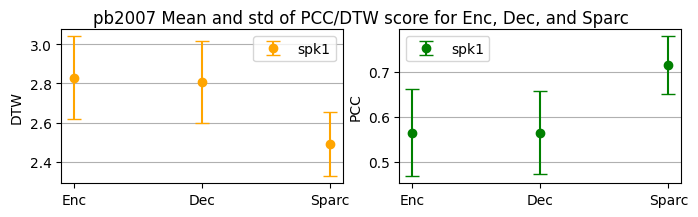

In [11]:
# Calculate mean and standard deviation for enc, dec, and sparc
means = [
    spk1_df["dtw_gt_enc"].mean(),
    spk1_df["dtw_gt_dec"].mean(),
    spk1_df["dtw_gt_sparc"].mean()
]
stds = [
    spk1_df["dtw_gt_enc"].std(),
    spk1_df["dtw_gt_dec"].std(),
    spk1_df["dtw_gt_sparc"].std()
]

# Labels for the bars
labels = ["Enc", "Dec", "Sparc"]

# Plot the bar chart
fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharey=False, sharex=True)
#plot stds
ax[0].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='spk1', color='orange')
ax[0].set_ylabel("DTW")
ax[0].grid(axis='y')
ax[0].legend()

means = [
    spk1_df["pcc_gt_enc"].mean(),
    spk1_df["pcc_gt_dec"].mean(),
    spk1_df["pcc_gt_sparc"].mean()
]
stds = [
    spk1_df["pcc_gt_enc"].std(),
    spk1_df["pcc_gt_dec"].std(),
    spk1_df["pcc_gt_sparc"].std()
]


ax[1].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='spk1', color='green')

ax[1].set_ylabel("PCC")
ax[1].grid(axis='y')
ax[1].legend()

plt.suptitle(f"{dataset} Mean and std of PCC/DTW score for Enc, Dec, and Sparc")
#plt.tight_layout()
plt.show()


# mocha_timit

In [12]:
from utils_dataset.mocha import get_mochatimit_ema

dataset = "mocha_timit"
speakers = ['fsew0', 'faet0', 'maps0', 'msak0', 'mjjn0', 'ffes0']
spkmetadata_filenames = ["mixed_speaker_metadata_100Hz.joblib",
                         "nonmixed_speaker_metadata_100Hz.joblib",
                         "speaker_metadata_100Hz.joblib",
                         "nonmixed_speaker_metadata_50Hz.joblib",
                         "speaker_metadata_50Hz.joblib"]

processed_data_dir = DATA_DIR / dataset / "processed_data"

for speaker in speakers[:6]:
    print(f"Processing speaker: {speaker}")
    for spkmetadata_filename in spkmetadata_filenames[:1]:
        if not (processed_data_dir / speaker / spkmetadata_filename).exists():
            print(f"File {spkmetadata_filename} does not exist for speaker {speaker}.")
            continue
        spkmeta = joblib.load(processed_data_dir / f"{speaker}/{spkmetadata_filename}")
        ids = spkmeta.list_valid_ids()
        # get the PCC scores and other metadata for each sentence
        pcc_scores = []
        filestems = []
        splits = []
        durations = []
        sentence_types = []
        for id in ids:
            sentencemeta = spkmeta.sentence_info[id]
            filestems.append(sentencemeta.filestem)
            splits.append(sentencemeta.split)
            pcc_scores.append(sentencemeta.PCC_score)
            durations.append(sentencemeta.duration)
            sentence_types.append(sentencemeta.sentence_type)

        summary_df = pd.DataFrame({
                                    "filestem": filestems,
                                    "split": splits,
                                    "pcc": pcc_scores,
                                    "duration": durations,
                                })
        summary_df = summary_df.sort_values(by="pcc", ascending=False)

    # get their sparc reconstruction
    arttts_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "arttts_pred" / "v1" / "grad_4750_align"
    sparc_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "emasrc"
    gt_ema_dir = DATA_DIR / dataset / "src_data" / speaker
    linearmodel_dir = DATA_DIR / dataset / "processed_data" / speaker / "linear_models"
    linearmodel = joblib.load(linearmodel_dir / "mixed_model_full_100Hz.joblib")
    analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
    analysis_dir.mkdir(parents=True, exist_ok=True)

    data = []
    for i, row in tqdm(summary_df.iterrows()):
        new_row = {
            "filestem": row["filestem"],
            "split": row["split"],
            "pcc": row["pcc"],
            "duration": row["duration"],
        }
        filestem = row["filestem"]
        arttts_ema = np.load(arttts_pred_dir / f"{filestem}.npy")
        enc_ema = arttts_ema[:12,:].T
        dec_ema = arttts_ema[14:26,:].T
        sparc_ema = np.load(sparc_pred_dir / f"{filestem}.npy")[:,:12]
        gt_ema = get_mochatimit_ema(gt_ema_dir / f"{filestem}.ema")[::10,:12]
        gt_ema = (gt_ema - np.mean(gt_ema, axis=0)) / np.std(gt_ema, axis=0)
        enc_ema = (enc_ema - np.mean(enc_ema, axis=0)) / np.std(enc_ema, axis=0)
        dec_ema = (dec_ema - np.mean(dec_ema, axis=0)) / np.std(dec_ema, axis=0)
        sparc_ema = (sparc_ema - np.mean(sparc_ema, axis=0)) / np.std(sparc_ema, axis=0)
        enc_ema = linearmodel.predict(enc_ema)
        dec_ema = linearmodel.predict(dec_ema)
        sparc_ema = linearmodel.predict(sparc_ema)
        #gt_ema = linearmodel.predict(gt_ema)
        dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(gt_ema, enc_ema)
        dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(gt_ema, dec_ema)
        dist_gt_sparc, y_gt_sparc_ada, y_sparc_14_ada = normalized_dtw_score(gt_ema, sparc_ema)
        pearson_enc, _ = pearsonr(y_gt_enc_ada, y_enc_14_ada)
        pearson_dec, _ = pearsonr(y_gt_dec_ada, y_dec_14_ada)
        pearson_sparc, _ = pearsonr(y_gt_sparc_ada, y_sparc_14_ada)
        new_row["dtw_gt_enc"] = dist_gt_enc
        new_row["dtw_gt_dec"] = dist_gt_dec
        new_row["dtw_gt_sparc"] = dist_gt_sparc
        new_row["pcc_gt_enc"] = np.mean(pearson_enc[:12])
        new_row["pcc_gt_dec"] = np.mean(pearson_dec[:12])
        new_row["pcc_gt_sparc"] = np.mean(pearson_sparc[:12])
        data.append(new_row)
    
    res_df = pd.DataFrame(data)
    res_df.to_csv(analysis_dir / "quanti_art_comp_align.csv", index=False)

Processing speaker: fsew0


0it [00:00, ?it/s]

455it [00:04, 105.59it/s]


Processing speaker: faet0


453it [00:04, 98.90it/s] 


Processing speaker: maps0


454it [00:04, 97.45it/s] 


Processing speaker: msak0


459it [00:04, 100.09it/s]


Processing speaker: mjjn0


459it [00:04, 94.63it/s] 


Processing speaker: ffes0


458it [00:04, 98.40it/s] 


In [13]:
speaker = "fsew0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
fsew0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
fsew0_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.739324,4.008866,2.592961,2.600581,2.258530,0.640908,0.631115,0.743833
std,0.049798,0.667091,0.187528,0.183742,0.166062,0.065312,0.064131,0.049749
min,0.393183,2.218375,2.160707,2.172317,1.932162,0.370888,0.295325,0.397506
25%,0.717090,3.468688,2.453962,2.469722,2.147157,0.600514,0.596568,0.722409
50%,0.745361,3.968375,2.580628,2.590771,2.242232,0.645678,0.641952,0.751368
75%,0.772243,4.468156,2.721385,2.701467,2.336512,0.688729,0.679223,0.775338
max,0.833785,6.718938,3.324320,3.576881,3.259215,0.788091,0.779147,0.839687


In [14]:
speaker = "faet0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
faet0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
faet0_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000,453.000000
mean,0.696867,3.944828,2.712569,2.677516,2.370316,0.576392,0.578979,0.705032
std,0.059960,0.616285,0.184028,0.175256,0.153051,0.074058,0.066646,0.050974
min,0.029140,2.468187,2.235130,2.172965,2.031656,0.262970,0.316782,0.460100
25%,0.672428,3.468437,2.587133,2.555585,2.260077,0.535876,0.540128,0.671198
50%,0.702007,3.967687,2.694902,2.666275,2.361960,0.585385,0.585991,0.711867
75%,0.735572,4.218813,2.821534,2.787162,2.457919,0.627161,0.623465,0.742382
max,0.843952,6.030875,3.444417,3.298066,2.985964,0.734884,0.735299,0.827057


In [15]:
speaker = "ffes0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
ffes0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
ffes0_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000
mean,0.757506,4.053122,2.721696,2.634478,2.183560,0.593029,0.613271,0.766647
std,0.051650,0.627530,0.200269,0.207705,0.173980,0.072033,0.069796,0.046859
min,0.480817,2.218125,2.267937,2.086863,1.745298,0.247002,0.362609,0.575383
25%,0.730408,3.716656,2.577645,2.495247,2.072858,0.549515,0.569736,0.743966
50%,0.765897,3.967938,2.717384,2.621245,2.160737,0.600978,0.618673,0.775106
75%,0.794057,4.467875,2.845119,2.765111,2.270834,0.645469,0.664785,0.797761
max,0.853110,5.968187,3.500209,3.362186,2.852587,0.733562,0.771151,0.859433


In [16]:
speaker = "maps0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
maps0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
maps0_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000,454.000000
mean,0.729240,3.761621,2.664563,2.633495,2.234234,0.623722,0.623347,0.745663
std,0.052013,0.594107,0.222991,0.220061,0.194817,0.074227,0.071832,0.051859
min,0.541446,2.397125,2.099192,2.129501,1.756111,0.402511,0.374127,0.548881
25%,0.699013,3.292937,2.510521,2.491582,2.091113,0.581065,0.582539,0.715339
50%,0.733562,3.714938,2.658077,2.625215,2.218870,0.631227,0.633928,0.751221
75%,0.767525,4.125047,2.798841,2.754494,2.360700,0.680481,0.669188,0.783684
max,0.829222,5.788938,3.309214,3.338406,2.907686,0.785368,0.786505,0.860100


In [17]:
speaker = "mjjn0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
mjjn0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
mjjn0_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000
mean,0.724636,4.424035,2.670497,2.649500,2.268195,0.623896,0.615258,0.733862
std,0.051629,0.653753,0.203389,0.196964,0.167393,0.068142,0.066018,0.048631
min,0.350603,2.968313,2.126281,2.085408,1.894090,0.367539,0.378817,0.469411
25%,0.698931,3.968375,2.528539,2.501142,2.156960,0.584158,0.573623,0.707466
50%,0.734211,4.218687,2.661719,2.640203,2.257672,0.630667,0.619842,0.742208
75%,0.757738,4.718500,2.799363,2.782277,2.360299,0.671197,0.663603,0.765291
max,0.830921,6.717937,3.382956,3.342317,3.054918,0.784651,0.783772,0.838543


In [18]:
speaker = "msak0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
msak0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
msak0_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000
mean,0.751476,3.957179,2.537169,2.495648,2.155033,0.664099,0.668637,0.765080
std,0.048271,0.575997,0.213199,0.195101,0.167454,0.064495,0.058596,0.043468
min,0.384357,2.468625,1.970778,1.978943,1.648809,0.432149,0.481999,0.509662
25%,0.727724,3.468938,2.390553,2.362510,2.040717,0.628900,0.633949,0.741712
50%,0.756950,3.967938,2.515730,2.471842,2.142240,0.671726,0.675710,0.770744
75%,0.783526,4.218969,2.663238,2.621886,2.262213,0.706206,0.710119,0.796088
max,0.872472,5.718125,3.209893,3.062537,3.065999,0.816805,0.807592,0.877582


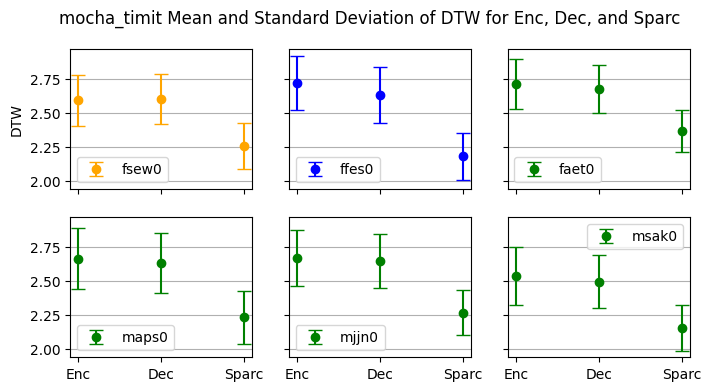

In [19]:
# Calculate mean and standard deviation for enc, dec, and sparc
means = [
    fsew0_df["dtw_gt_enc"].mean(),
    fsew0_df["dtw_gt_dec"].mean(),
    fsew0_df["dtw_gt_sparc"].mean()
]
stds = [
    fsew0_df["dtw_gt_enc"].std(),
    fsew0_df["dtw_gt_dec"].std(),
    fsew0_df["dtw_gt_sparc"].std()
]

# Labels for the bars
labels = ["Enc", "Dec", "Sparc"]

# Plot the bar chart
fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharey=True, sharex=True)
#flatten the axes array for easier indexing
ax = ax.flatten()

#plot stds
ax[0].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='fsew0', color='orange')
ax[0].grid(axis='y')

means = [
    ffes0_df["dtw_gt_enc"].mean(),
    ffes0_df["dtw_gt_dec"].mean(),
    ffes0_df["dtw_gt_sparc"].mean()
]
stds = [
    ffes0_df["dtw_gt_enc"].std(),
    ffes0_df["dtw_gt_dec"].std(),
    ffes0_df["dtw_gt_sparc"].std()
]
ax[1].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='ffes0', color='blue')
ax[1].grid(axis='y')

means = [
    faet0_df["dtw_gt_enc"].mean(),
    faet0_df["dtw_gt_dec"].mean(),
    faet0_df["dtw_gt_sparc"].mean()
]
stds = [
    faet0_df["dtw_gt_enc"].std(),
    faet0_df["dtw_gt_dec"].std(), 
    faet0_df["dtw_gt_sparc"].std()
]
ax[2].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='faet0', color='green')
ax[2].grid(axis='y')

means = [
    maps0_df["dtw_gt_enc"].mean(),
    maps0_df["dtw_gt_dec"].mean(),
    maps0_df["dtw_gt_sparc"].mean()
]
stds = [
    maps0_df["dtw_gt_enc"].std(),
    maps0_df["dtw_gt_dec"].std(), 
    maps0_df["dtw_gt_sparc"].std()
]
ax[3].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='maps0', color='green')
ax[3].grid(axis='y')

means = [
    mjjn0_df["dtw_gt_enc"].mean(),
    mjjn0_df["dtw_gt_dec"].mean(),
    mjjn0_df["dtw_gt_sparc"].mean()
]
stds = [
    mjjn0_df["dtw_gt_enc"].std(),
    mjjn0_df["dtw_gt_dec"].std(), 
    mjjn0_df["dtw_gt_sparc"].std()
]
ax[4].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='mjjn0', color='green')
ax[4].grid(axis='y')

means = [
    msak0_df["dtw_gt_enc"].mean(),
    msak0_df["dtw_gt_dec"].mean(),
    msak0_df["dtw_gt_sparc"].mean()
]
stds = [
    msak0_df["dtw_gt_enc"].std(),
    msak0_df["dtw_gt_dec"].std(), 
    msak0_df["dtw_gt_sparc"].std()
]
ax[5].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='msak0', color='green')
ax[5].grid(axis='y')

ax[0].set_ylabel("DTW")
plt.suptitle(f"{dataset} Mean and Standard Deviation of DTW for Enc, Dec, and Sparc")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
#plt.tight_layout()
plt.show()


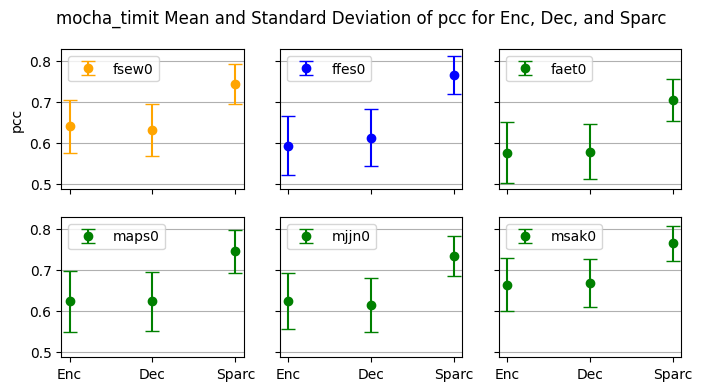

In [20]:
# Calculate mean and standard deviation for enc, dec, and sparc
means = [
    fsew0_df["pcc_gt_enc"].mean(),
    fsew0_df["pcc_gt_dec"].mean(),
    fsew0_df["pcc_gt_sparc"].mean()
]
stds = [
    fsew0_df["pcc_gt_enc"].std(),
    fsew0_df["pcc_gt_dec"].std(),
    fsew0_df["pcc_gt_sparc"].std()
]

# Labels for the bars
labels = ["Enc", "Dec", "Sparc"]

# Plot the bar chart
fig, ax = plt.subplots(2, 3, figsize=(8, 4), sharey=True, sharex=True)
#flatten the axes array for easier indexing
ax = ax.flatten()

#plot stds
ax[0].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='fsew0', color='orange')
ax[0].grid(axis='y')

means = [
    ffes0_df["pcc_gt_enc"].mean(),
    ffes0_df["pcc_gt_dec"].mean(),
    ffes0_df["pcc_gt_sparc"].mean()
]
stds = [
    ffes0_df["pcc_gt_enc"].std(),
    ffes0_df["pcc_gt_dec"].std(),
    ffes0_df["pcc_gt_sparc"].std()
]
ax[1].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='ffes0', color='blue')
ax[1].grid(axis='y')

means = [
    faet0_df["pcc_gt_enc"].mean(),
    faet0_df["pcc_gt_dec"].mean(),
    faet0_df["pcc_gt_sparc"].mean()
]
stds = [
    faet0_df["pcc_gt_enc"].std(),
    faet0_df["pcc_gt_dec"].std(), 
    faet0_df["pcc_gt_sparc"].std()
]
ax[2].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='faet0', color='green')
ax[2].grid(axis='y')

means = [
    maps0_df["pcc_gt_enc"].mean(),
    maps0_df["pcc_gt_dec"].mean(),
    maps0_df["pcc_gt_sparc"].mean()
]
stds = [
    maps0_df["pcc_gt_enc"].std(),
    maps0_df["pcc_gt_dec"].std(), 
    maps0_df["pcc_gt_sparc"].std()
]
ax[3].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='maps0', color='green')
ax[3].grid(axis='y')

means = [
    mjjn0_df["pcc_gt_enc"].mean(),
    mjjn0_df["pcc_gt_dec"].mean(),
    mjjn0_df["pcc_gt_sparc"].mean()
]
stds = [
    mjjn0_df["pcc_gt_enc"].std(),
    mjjn0_df["pcc_gt_dec"].std(), 
    mjjn0_df["pcc_gt_sparc"].std()
]
ax[4].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='mjjn0', color='green')
ax[4].grid(axis='y')

means = [
    msak0_df["pcc_gt_enc"].mean(),
    msak0_df["pcc_gt_dec"].mean(),
    msak0_df["pcc_gt_sparc"].mean()
]
stds = [
    msak0_df["pcc_gt_enc"].std(),
    msak0_df["pcc_gt_dec"].std(), 
    msak0_df["pcc_gt_sparc"].std()
]
ax[5].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='msak0', color='green')
ax[5].grid(axis='y')

ax[0].set_ylabel("pcc")
plt.suptitle(f"{dataset} Mean and Standard Deviation of pcc for Enc, Dec, and Sparc")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
#plt.tight_layout()
plt.show()


# MNGU0

In [21]:
dataset = "MNGU0"
speaker = "s1"
src_data_dir = DATA_DIR / dataset / "src_data" / speaker / "ema_basic_data"
emasrc_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "emasrc"
spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
reconstructed_dir = DATA_DIR / dataset / "arttts" / speaker / "hifigan_pred"

/tmp/ipykernel_1901123/1569066692.py:12: RuntimeWarning: invalid value encountered in divide
  ema_data_14 = (ema_data_14 - ema_data_14.mean(axis=0)) / ema_data_14.std(axis=0)


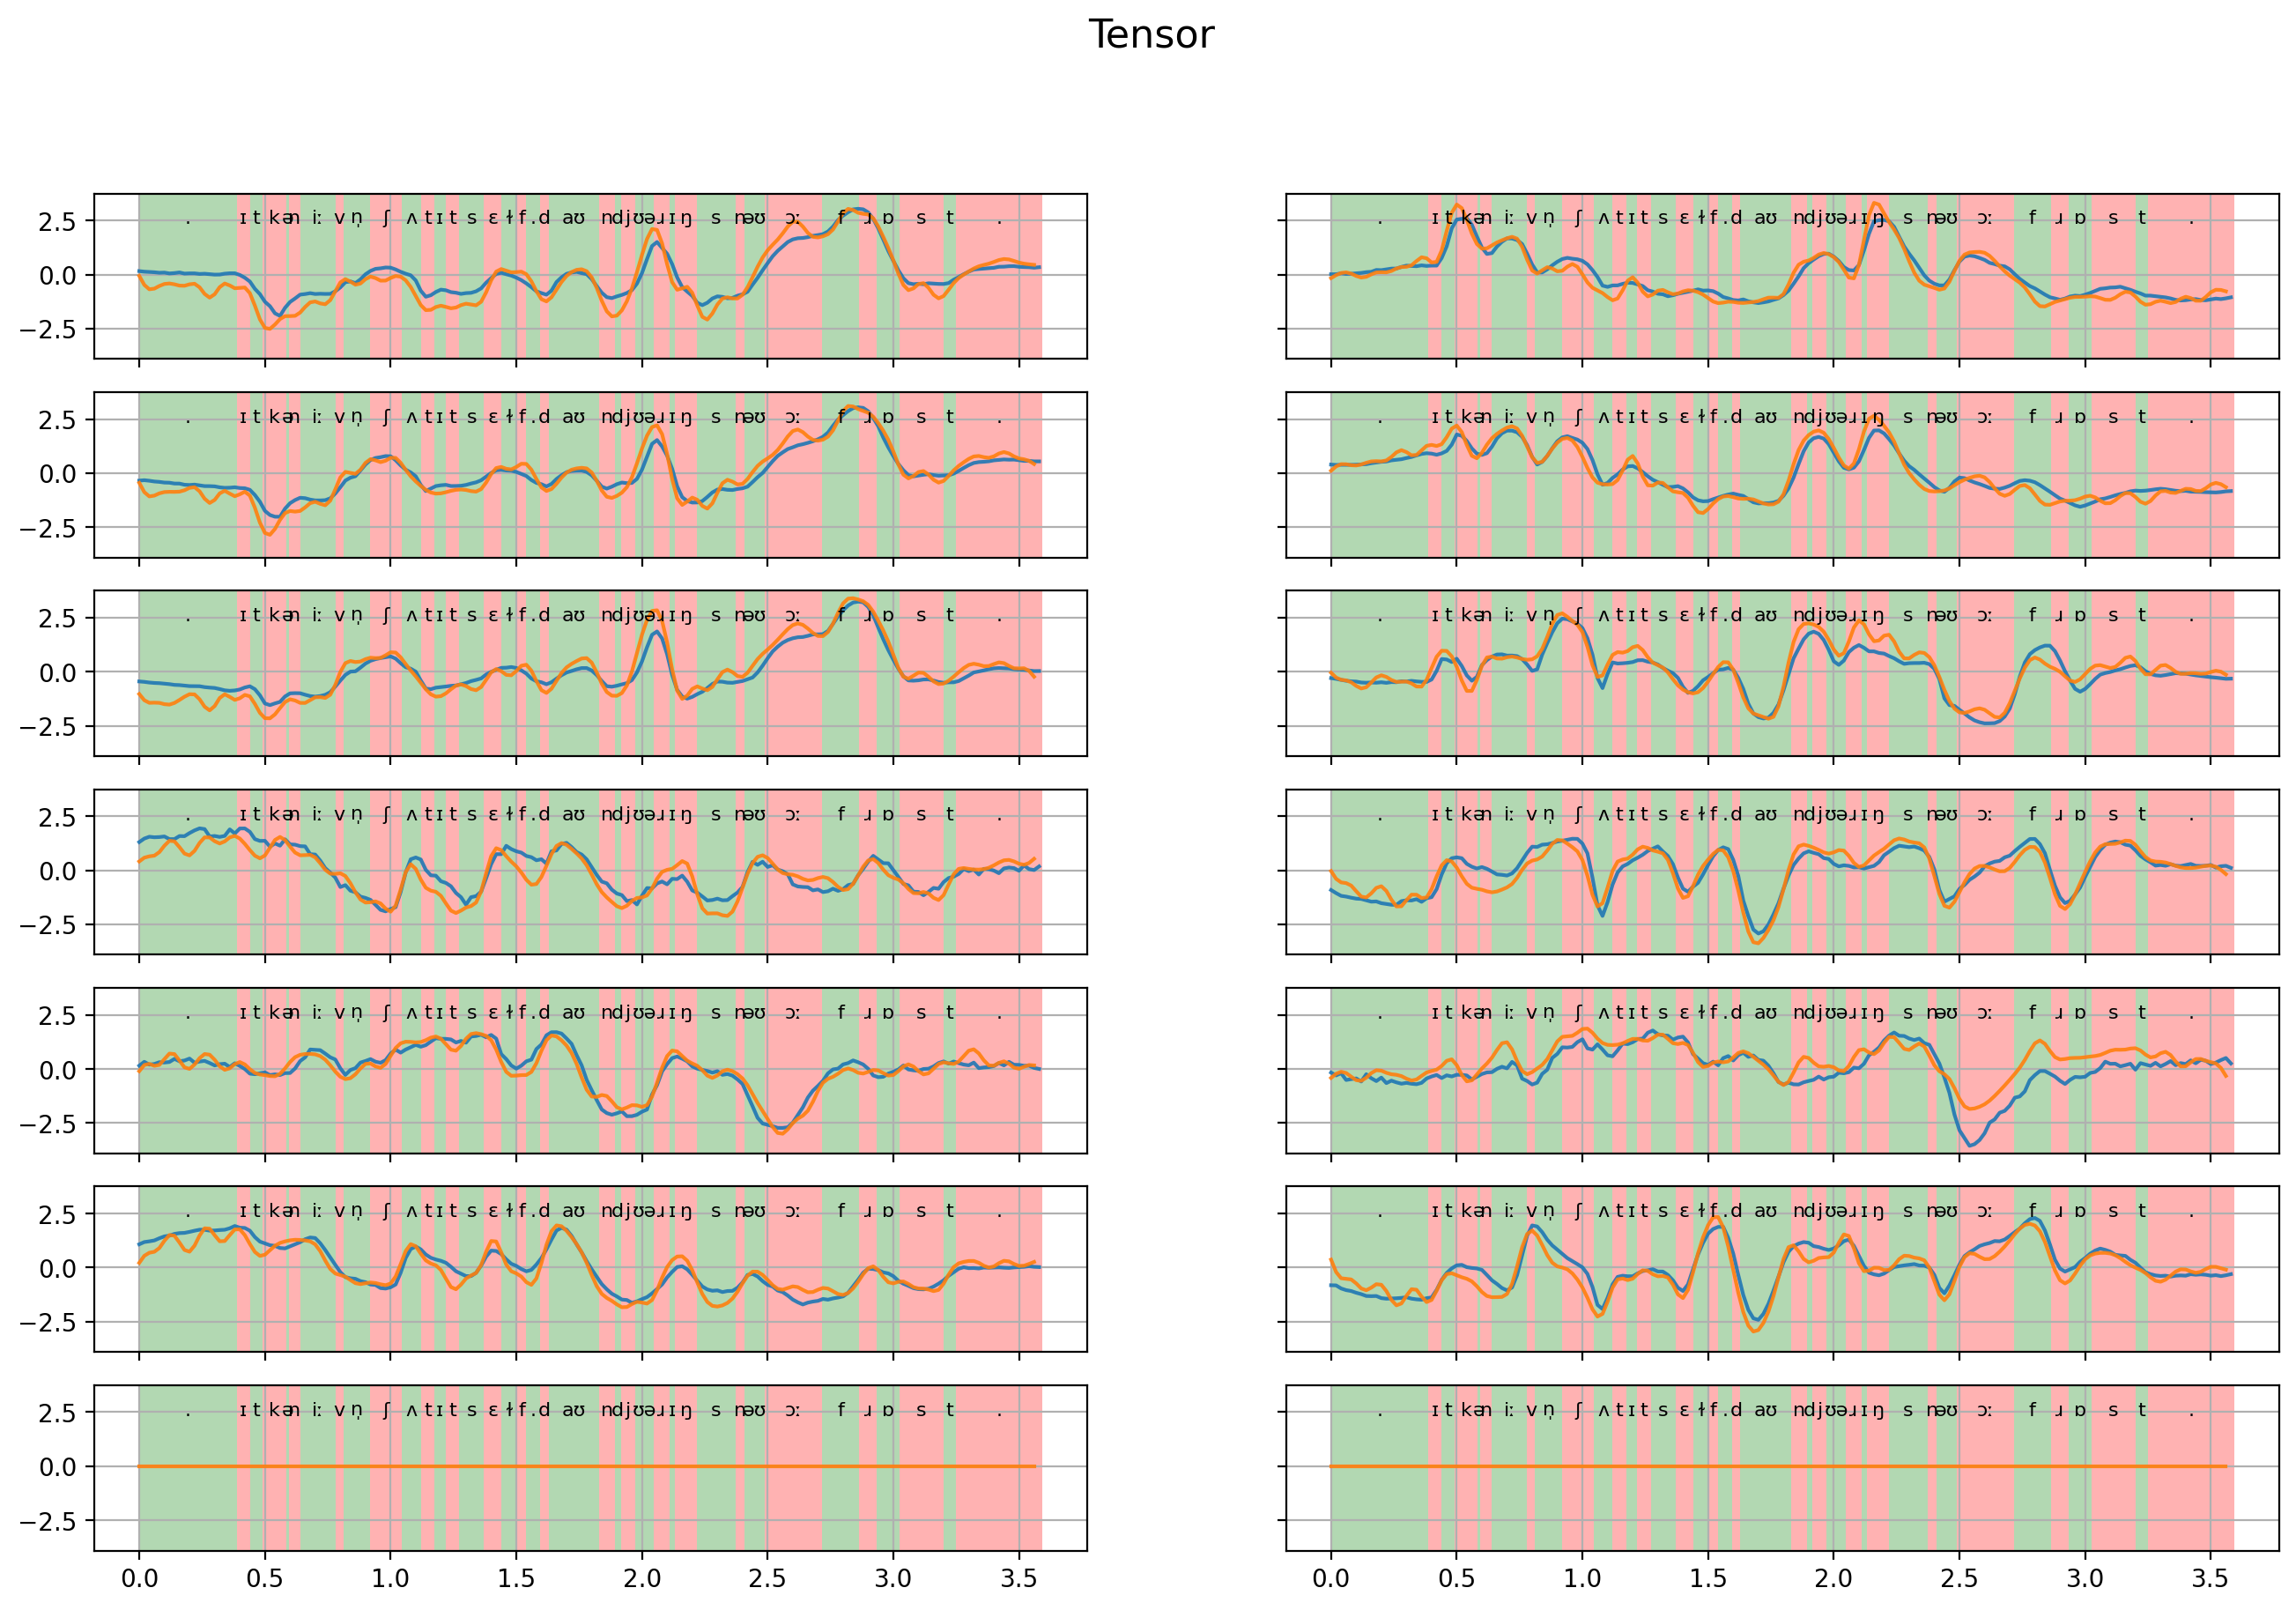

In [22]:
from utils_dataset.mngu0 import read_mngu0_ema, MNGU0_features
from utils import plot_art_14

raw_ema_fp = list(src_data_dir.glob("*"))[522]
raw_ema_fp = raw_ema_fp.parent / "mngu0_s1_1215.ema"
sample_id = raw_ema_fp.stem
ema_data, nonan = read_mngu0_ema(raw_ema_fp)
sparc_ema = np.load(emasrc_dir / f"{sample_id}.npy")[:,:12]
phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")

ema_data_14 = np.pad(ema_data, ((0, 0), (0, 2)), mode='constant', constant_values=0)
ema_data_14 = (ema_data_14 - ema_data_14.mean(axis=0)) / ema_data_14.std(axis=0)
ema_data_14 = ema_data_14[::4,:]
sparc_ema_14 = np.pad(sparc_ema, ((0, 0), (0, 2)), mode='constant', constant_values=0)

fig, _ = plot_art_14([ema_data_14.T,
                       sparc_ema_14.T],
                       phnm3=phnm3,
                       figsize=(16, 10),)
fig

In [24]:
from scipy.stats import pearsonr
from utils_dataset.mngu0 import read_mngu0_ema

speaker = "s1"
filestems = []
pccs = []
durations = []
for raw_ema_fp in list(src_data_dir.glob("*.ema")):
    sample_id = raw_ema_fp.stem
    ema_data, nonan = read_mngu0_ema(raw_ema_fp)
    if nonan: #and ema_data.shape[0] / 4 > 150:
        filestems.append(sample_id)
        durations.append(ema_data.shape[0] / 200) # Original data 200 Hz
        ema_data = (ema_data - ema_data.mean(axis=0)) / ema_data.std(axis=0)
        ema_data = ema_data[::4,:]  # TO 50 Hz
        sparc_ema = np.load(emasrc_dir / f"{sample_id}.npy")[:,:12]
        #phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
        pcc, _ = pearsonr(sparc_ema, ema_data[:sparc_ema.shape[0]])
        pccs.append(pcc)
pccs = np.array(pccs)

summary_df = pd.DataFrame({
    "filestem": filestems,
    "pcc": pccs.mean(axis=1),
    "duration": durations
})
summary_df = summary_df.sort_values(by="pcc", ascending=False)

processed_data_dir = DATA_DIR / dataset / "processed_data"


# get their sparc reconstruction
arttts_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "arttts_pred" / "v1" / "grad_4750_align"
sparc_pred_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "emasrc"
gt_ema_dir = DATA_DIR / dataset / "src_data" / speaker / "ema_basic_data"
#linearmodel_dir = DATA_DIR / dataset / "processed_data" / speaker / "linear_models"
#linearmodel = joblib.load(linearmodel_dir / "mixed_model_full_100Hz.joblib")
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
analysis_dir.mkdir(parents=True, exist_ok=True)

data = []
for i, row in tqdm(summary_df.iterrows()):
    new_row = {
        "filestem": row["filestem"],
        "pcc": row["pcc"],
        "duration": row["duration"],
    }
    filestem = row["filestem"]
    arttts_ema = np.load(arttts_pred_dir / f"{filestem}.npy")
    enc_ema = arttts_ema[:12,:].T
    dec_ema = arttts_ema[14:26,:].T
    sparc_ema = np.load(sparc_pred_dir / f"{filestem}.npy")[:,:12]
    gt_ema = read_mngu0_ema(gt_ema_dir / f"{filestem}.ema")[0][::4,:12]
    gt_ema = (gt_ema - np.mean(gt_ema, axis=0)) / np.std(gt_ema, axis=0)
    #enc_ema = (enc_ema - np.mean(enc_ema, axis=0)) / np.std(enc_ema, axis=0)
    #dec_ema = (dec_ema - np.mean(dec_ema, axis=0)) / np.std(dec_ema, axis=0)
    #sparc_ema = (sparc_ema - np.mean(sparc_ema, axis=0)) / np.std(sparc_ema, axis=0)
    #enc_ema = linearmodel.predict(enc_ema)
    #dec_ema = linearmodel.predict(dec_ema)
    #sparc_ema = linearmodel.predict(sparc_ema)
    #gt_ema = linearmodel.predict(gt_ema)
    dist_gt_enc, y_gt_enc_ada, y_enc_14_ada = normalized_dtw_score(gt_ema, enc_ema)
    dist_gt_dec, y_gt_dec_ada, y_dec_14_ada = normalized_dtw_score(gt_ema, dec_ema)
    dist_gt_sparc, y_gt_sparc_ada, y_sparc_14_ada = normalized_dtw_score(gt_ema, sparc_ema)
    pearson_enc, _ = pearsonr(y_gt_enc_ada, y_enc_14_ada)
    pearson_dec, _ = pearsonr(y_gt_dec_ada, y_dec_14_ada)
    pearson_sparc, _ = pearsonr(y_gt_sparc_ada, y_sparc_14_ada)
    new_row["dtw_gt_enc"] = dist_gt_enc
    new_row["dtw_gt_dec"] = dist_gt_dec
    new_row["dtw_gt_sparc"] = dist_gt_sparc
    new_row["pcc_gt_enc"] = np.mean(pearson_enc[:12])
    new_row["pcc_gt_dec"] = np.mean(pearson_dec[:12])
    new_row["pcc_gt_sparc"] = np.mean(pearson_sparc[:12])
    data.append(new_row)

res_df = pd.DataFrame(data)
res_df.to_csv(analysis_dir / "quanti_art_comp_align.csv", index=False)

1312it [00:09, 135.36it/s]


In [25]:
speaker = "s1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
s1_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")
s1_df.describe()

,pcc,duration,dtw_gt_enc,dtw_gt_dec,dtw_gt_sparc,pcc_gt_enc,pcc_gt_dec,pcc_gt_sparc
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000
mean,0.854605,3.835530,2.677816,2.703671,1.772634,0.743489,0.741805,0.874679
std,0.056925,2.415233,0.337355,0.296406,0.274668,0.089110,0.080274,0.052969
min,0.516788,0.870000,2.034252,1.761269,1.281996,0.146984,0.121591,0.537470
25%,0.833965,2.272500,2.443133,2.519360,1.566755,0.713664,0.712352,0.853036
50%,0.869662,3.060000,2.614794,2.668479,1.714877,0.765492,0.758982,0.889531
75%,0.893249,4.606250,2.853961,2.861107,1.927080,0.799770,0.791466,0.910689
max,0.935852,17.035000,4.545287,4.513228,3.151671,0.892097,0.893816,0.942715


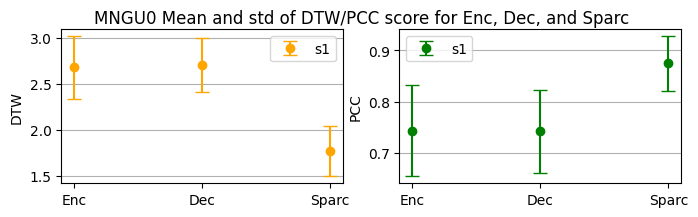

In [26]:
# Calculate mean and standard deviation for enc, dec, and sparc
means = [
    s1_df["dtw_gt_enc"].mean(),
    s1_df["dtw_gt_dec"].mean(),
    s1_df["dtw_gt_sparc"].mean()
]
stds = [
    s1_df["dtw_gt_enc"].std(),
    s1_df["dtw_gt_dec"].std(),
    s1_df["dtw_gt_sparc"].std()
]

# Labels for the bars
labels = ["Enc", "Dec", "Sparc"]

# Plot the bar chart
fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharey=False, sharex=True)
#plot stds
ax[0].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='s1', color='orange')
ax[0].set_ylabel("DTW")
ax[0].grid(axis='y')
ax[0].legend()

means = [
    s1_df["pcc_gt_enc"].mean(),
    s1_df["pcc_gt_dec"].mean(),
    s1_df["pcc_gt_sparc"].mean()
]
stds = [
    s1_df["pcc_gt_enc"].std(),
    s1_df["pcc_gt_dec"].std(),
    s1_df["pcc_gt_sparc"].std()
]


ax[1].errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='s1', color='green')

ax[1].set_ylabel("PCC")
ax[1].grid(axis='y')
ax[1].legend()

plt.suptitle(f"{dataset} Mean and std of DTW/PCC score for Enc, Dec, and Sparc")
#plt.tight_layout()
plt.show()


# Phoneme level analysis

In [27]:
from text.phnms import get_phnms_from_phnm3
from text.converters import arpabet2ipa

lj_ipa_set = set(arpabet2ipa.values())

## MSPKA_EMA_ita

In [28]:
from utils_dataset.mspka import mspka2ipa

mspka_ipa_set = set(mspka2ipa.values())
extra_ipa_set = mspka_ipa_set - lj_ipa_set

dataset = "MSPKA_EMA_ita"
speakers = ["cnz", "olm", "lls"]

In [29]:
phnms_stats = {}

speaker = "cnz"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
cnz_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in cnz_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "lls"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
lls_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in lls_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "olm"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
olm_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in olm_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

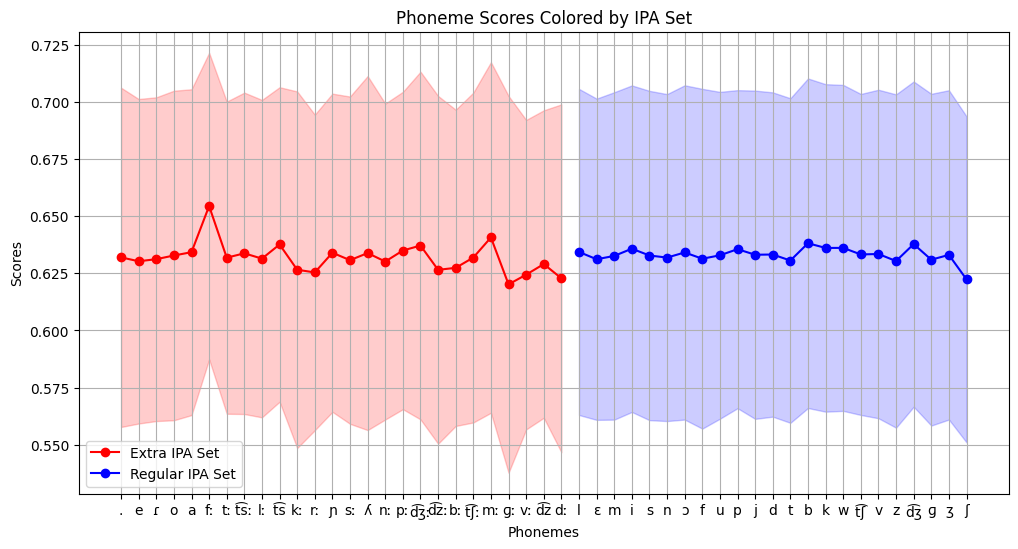

In [30]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## pb2007

In [62]:
from utils_dataset.pb2007 import pb20072ipa

pb2007_ipa_set = set(pb20072ipa.values())
extra_ipa_set = pb2007_ipa_set - lj_ipa_set

dataset = "pb2007"
speakers = ["spk1"]

In [63]:
phnms_stats = {}

speaker = "spk1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
spk1_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in spk1_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

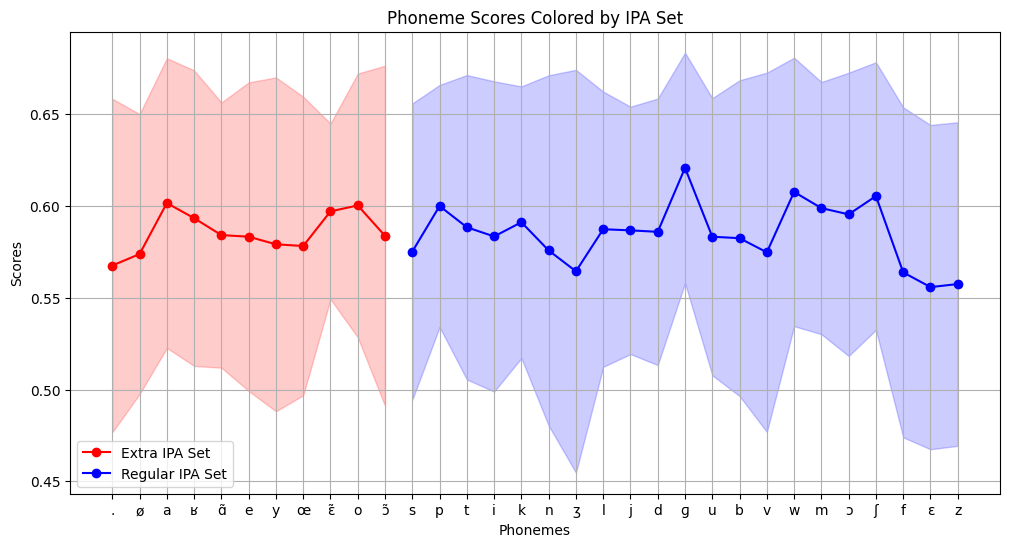

In [64]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## MNGU0

In [59]:
from utils_dataset.mngu0 import mngu02ipa

mngu0_ipa_set = set(mngu02ipa.values())
extra_ipa_set = mngu0_ipa_set - lj_ipa_set

dataset = "MNGU0"
speakers = ["spk1"]

In [60]:
phnms_stats = {}

speaker = "s1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
s1_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in s1_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

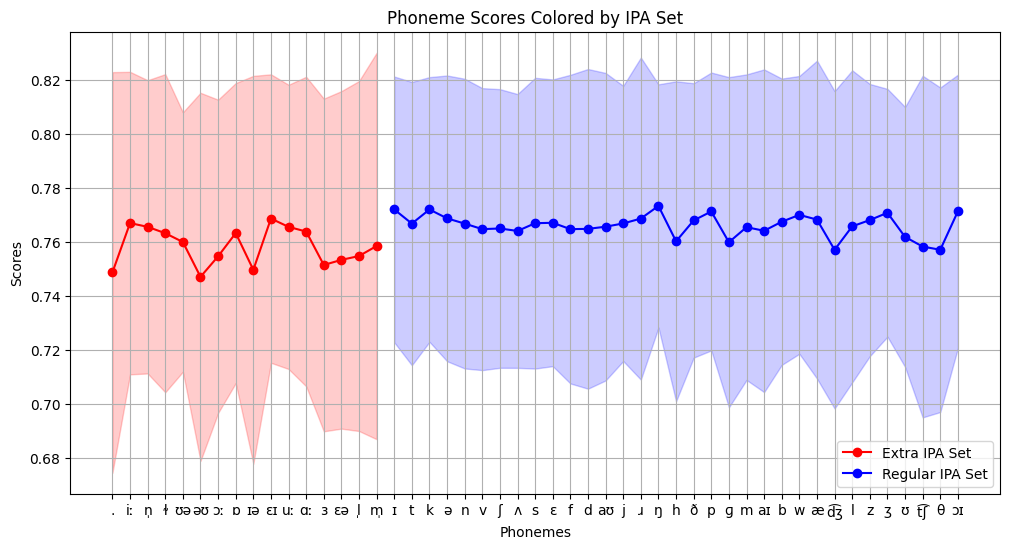

In [61]:
# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

## mocha_timit

In [37]:
dataset = "mocha_timit"
speakers = ["fsew0", "faet0", "ffes0", "maps0", "mjjn0", "msak0"]

In [38]:
phnms_stats = {}

speaker = "fsew0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
fsew0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in fsew0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "faet0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
faet0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in faet0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "ffes0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
ffes0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in ffes0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "maps0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
maps0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in maps0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "mjjn0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
mjjn0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in mjjn0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])

speaker = "msak0"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
phnm3_dir = DATA_DIR / dataset / "arttts" / speaker / "phnm3"
msak0_df = pd.read_csv(analysis_dir / "quanti_art_comp_align.csv")

for i, row in msak0_df.iterrows():
    sample_id = row["filestem"]
    phnm3 = np.load(phnm3_dir / f"{sample_id}_phnm3.npy")
    #phnms = get_phnms_from_phnm3(phnm3, merge_diphtongues=False)
    for start, end, phnm in phnm3:
        if phnm not in phnms_stats:
            phnms_stats[phnm] = [0, []]  # [count, score]
        phnms_stats[phnm][0] += 1
        phnms_stats[phnm][1].append(row["pcc_gt_dec"])
        
phnms_scores = {phnm: (count, np.mean(values), np.std(values)) for phnm, (count, values) in phnms_stats.items() if count > 10}

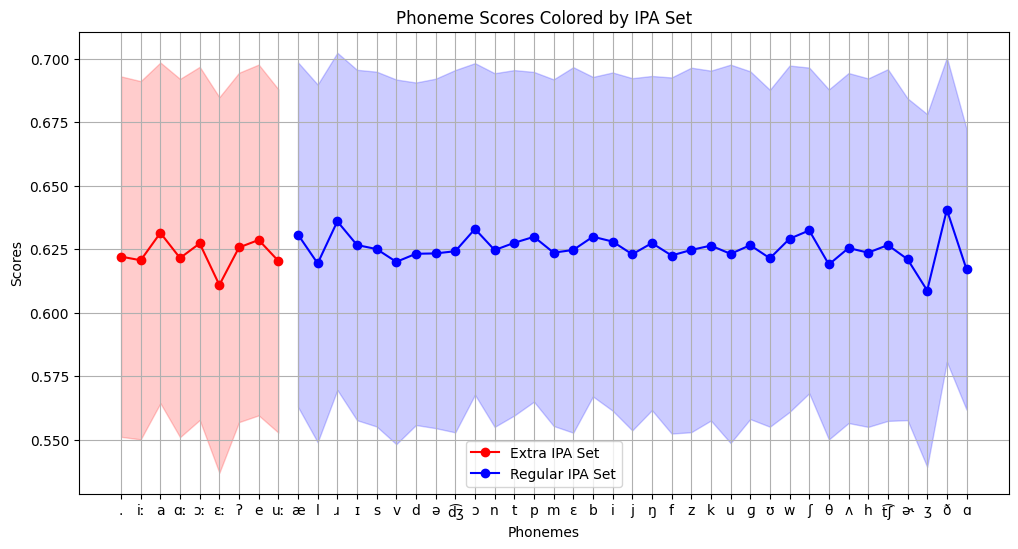

In [39]:
mocha_ipa_set = set(phnms_scores.keys())
extra_ipa_set = mocha_ipa_set - lj_ipa_set

# Separate phonemes into two groups based on their presence in extra_ipa_set
extra_phnms = [phnm for phnm in phnms_scores.keys() if phnm in extra_ipa_set]
regular_phnms = [phnm for phnm in phnms_scores.keys() if phnm not in extra_ipa_set]

# Extract scores for each group
extra_scores = [phnms_scores[phnm][1] for phnm in extra_phnms]
extra_stds = [phnms_scores[phnm][2] for phnm in extra_phnms]
regular_scores = [phnms_scores[phnm][1] for phnm in regular_phnms]
regular_stds = [phnms_scores[phnm][2] for phnm in regular_phnms]

# Plot the phonemes with different colors
plt.figure(figsize=(12, 6))
plt.plot(extra_phnms, extra_scores, marker='o', color='red', label='Extra IPA Set')
plt.plot(regular_phnms, regular_scores, marker='o', color='blue', label='Regular IPA Set')
#plot stds
plt.fill_between(extra_phnms, np.array(extra_scores) - np.array(extra_stds),
                    np.array(extra_scores) + np.array(extra_stds), color='red', alpha=0.2)
plt.fill_between(regular_phnms, np.array(regular_scores) - np.array(regular_stds),
                    np.array(regular_scores) + np.array(regular_stds), color='blue', alpha=0.2)

# Add legend and labels
plt.legend()
plt.xlabel("Phonemes")
plt.ylabel("Scores")
plt.title("Phoneme Scores Colored by IPA Set")
plt.grid()
plt.show()

# Pitch sensitivity

# Spk_emb sensitivity

## build mean spk_embs

In [96]:
dataset = "MNGU0"
speaker = "s1"
analysis_dir = DATA_DIR / dataset / "arttts" / speaker / "analysis"
s1_df = pd.read_csv(analysis_dir / "quanti_art_comp.csv")

spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

fp_list = list(spk_emb_dir.glob("*.npy"))
spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
for i, fp in enumerate(fp_list):
    sample_id = fp.stem
    spk_emb = np.load(fp)
    spk_embs[i, :] = spk_emb
np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

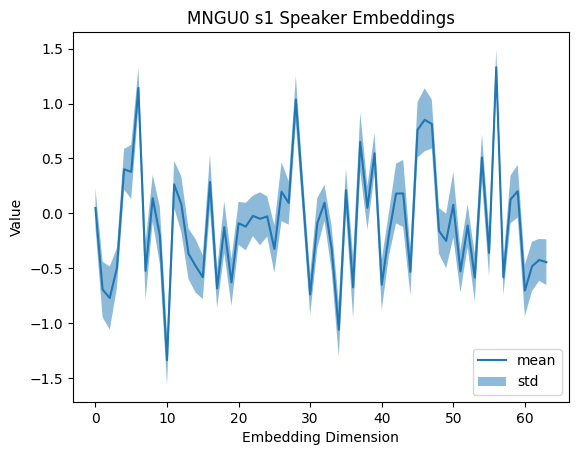

In [97]:
spk_embs.mean(axis=0), spk_embs.std(axis=0)
plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

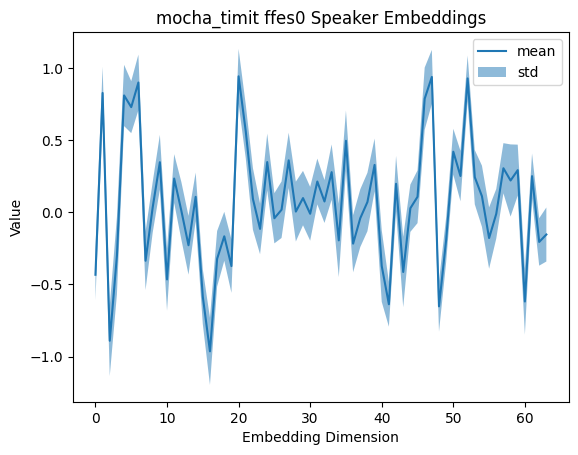

In [99]:
dataset = "mocha_timit"
speakers = ['fsew0', 'faet0', 'maps0', 'msak0', 'mjjn0', 'ffes0']
speaker = speakers[5]
for speaker in speakers:
    spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

    fp_list = list(spk_emb_dir.glob("*.npy"))
    spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
    for i, fp in enumerate(fp_list):
        sample_id = fp.stem
        spk_emb = np.load(fp)
        spk_embs[i, :] = spk_emb
    np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

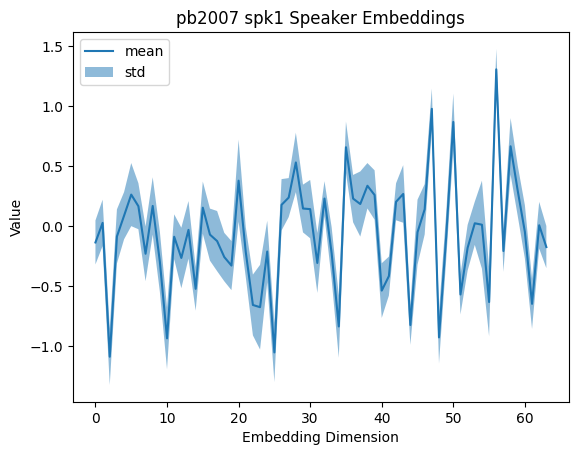

In [ ]:
spk1_sentences_df = spk1_df[spk1_df["sentence_types"] == "sentence"]

dataset = "pb2007"
speaker = "spk1"
spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

fp_list = list(spk_emb_dir.glob("*.npy"))
#only use sentences spk_emb
fp_list = [spk_emb_dir / f"{filestem}.npy" for filestem in spk1_sentences_df["filestem"]]
spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
for i, fp in enumerate(fp_list):
    sample_id = fp.stem
    spk_emb = np.load(fp)
    spk_embs[i, :] = spk_emb
np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()

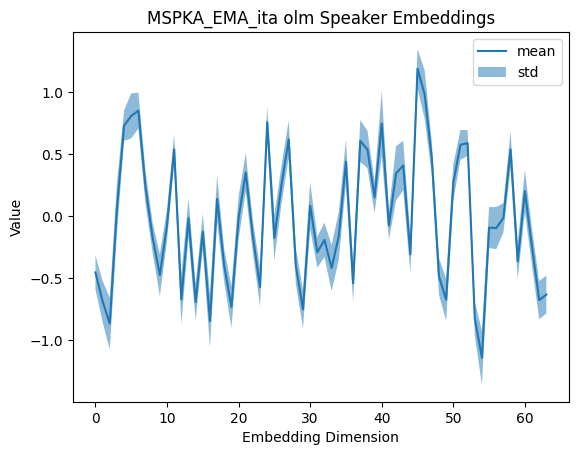

In [101]:
dataset = "MSPKA_EMA_ita"
speakers = ['cnz', 'lls', 'olm']

for speaker in speakers:
    spk_emb_dir = DATA_DIR / dataset / "arttts" / speaker / "encoded_audio_en" / "spk_emb"

    fp_list = list(spk_emb_dir.glob("*.npy"))
    spk_embs = np.zeros((len(fp_list), 64), dtype=np.float32)
    for i, fp in enumerate(fp_list):
        sample_id = fp.stem
        spk_emb = np.load(fp)
        spk_embs[i, :] = spk_emb
    np.save(spk_emb_dir / "mean_spk_emb.npy", spk_embs.mean(axis=0))

plt.plot(spk_embs.mean(axis=0), label="mean")
plt.fill_between(np.arange(64), spk_embs.mean(axis=0) - spk_embs.std(axis=0),
                 spk_embs.mean(axis=0) + spk_embs.std(axis=0), alpha=0.5, label="std")
plt.title(f"{dataset} {speaker} Speaker Embeddings")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.show()